# A fast, robust, physics-based model for the complete radial profile of tropical cyclone wind and pressure

#### Author: Dan Chavas (2025)

https://pypi.org/project/tcwindprofile/ : A package that creates fast, robust, physics-based radial profiles of the tropical cyclone rotating wind and pressure from inputs Vmax, R34kt, and latitude. Based on the latest observationally-validated science on the structure of the wind field and pressure.

Cite this package: [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.15442673.svg)](https://doi.org/10.5281/zenodo.15442673) . Also a paper is in prep with co-authors Dandan Tao and Robert Nystrom

Objective: To provide a faster and easier-to-use approximation to the physics-based wind model [code](https://doi.org/10.4231/CZ4P-D448) of Chavas+ (2015 JAS). That model is state-of-the-art, but slow. We want something faster/simpler that also better fits observations while staying true to the physics.



# Model motivation

The Chavas+ (2015) model has been extensively validated for real-world TCs, in terms of both physics and hazards/impacts:

Physics:
1. Reproduces characteristic TC wind structure from the entire QuikSCAT and HWIND databases ([Chavas+ 2015 JAS](https://doi.org/10.1175/JAS-D-15-0014.1))
2. Reproduces characteristic modes of TC wind field variability due to variations in intensity and outer size from the Extended Best Track database ([Chavas and Lin 2016 JAS](https://doi.org/10.1175/JAS-D-15-0185.1)).
3. Successfully predicts that wind field structure does not change significantly in a warmer world as seen in both climate-scale and storm-scale models ([Schenkel+ 2023](https://doi.org/10.1175/JCLI-D-22-0066.1))

Hazards/impacts:
4. When used as forcing for a surge model, it reproduces the historical record of U.S. peak storm surge remarkably well ([Gori+ 2023 JGR-A](https://doi.org/10.1029/2022JD037312)). It performs better than prevailing empirical wind field model [Wang+ 2022 JGR-A](https://doi.org/10.1029/2021JD036359)).
5. When used as forcing for a physics-based rainfall model, it reproduces the climatology of U.S. tropical cyclone inland rainfall remarkably well -- and dramatically better than existing empirical wind field models ([Xi+ 2020 J. Hydromet.](https://doi.org/10.1175/JHM-D-20-0035.1)).
6. When used to model all hazards (wind, coastal surge, inland flooding), predicts the county-level distribution of economic damage quite well ([Gori+ 2025 ERL, accepted](https://www.researchgate.net/publication/391588102_Sensitivity_of_tropical_cyclone_risk_across_the_US_to_changes_in_storm_climatology_and_socioeconomic_growth)).

# Model components

Full modeling pipeline:
1. Estimate Rmax from R34kt: ref [Chavas and Knaff 2022 WAF](https://doi.org/10.1175/WAF-D-21-0103.1) "A Simple Model for Predicting the Tropical Cyclone Radius of Maximum Wind from Outer Size"
2. Estimate R0 from R34kt: analytic approximate solution, from model of ref [Emanuel 2004](https://doi.org/10.1017/CBO9780511735035.010) ("Tropical cyclone energetics and structure") / [Chavas+ 2015 JAS](https://doi.org/10.1175/JAS-D-15-0014.1) "A model for the complete radial structure of the tropical cyclone wind field. Part I: Comparison with observed structure" / [Chavas and Lin 2016 JAS](https://doi.org/10.1175/JAS-D-15-0185.1) "Part II: Wind field variability"
3. Generate outer wind profile R34kt to R0: same refs as previous
4. Generate inner wind profile inside R34kt: mod rankine, ref [Fig 8 of Klotzbach et al. 2022 JGR-A](https://doi.org/10.1029/2022JD037030) ("Characterizing continental US hurricane risk: Which intensity metric is best?")
5. Generate complete wind profile: merge inner and outer
6. Estimate Pmin: ref [Chavas Knaff Klotzbach 2025 WAF](https://doi.org/10.1175/WAF-D-24-0031.1) ("A simple model for predicting tropical cyclone minimum central pressure from intensity and size")
7. Generate pressure profile that matches Pmin: same ref as previous


Currently, this code uses a quadratic profile inside the eye (r$<$Rmax), a modified‐Rankine vortex between Rmax and R34kt (inner model), and the E04 model beyond R34kt. It is very similar to the full physics-based wind profile model of Chavas et al. (2015) ([code here](http://doi.org/10.4231/CZ4P-D448)), but is simpler and much faster, and also includes a more reasonable eye model.

The model starts from the radius of 34kt, which is the most robust measure of size we have: it has long been routinely-estimated operationally; it is at a low enough wind speed to be accurately estimated by satellites over the ocean (higher confidence in data); and it is less noisy because it is typically outside the convective inner-core of the storm. The model then encodes the latest science to estimate 1) Rmax from R34kt (+ Vmax, latitude), 2) the radius of vanishing wind R0 from R34kt (+ latitude, an environmental constant), and 3) the minimum pressure Pmin from Vmax, R34kt, latitude, translation speed, and environmental pressure. Hence, it is very firmly grounded in the known physics of the tropical cyclone wind field while also matching the input data. It is also guaranteed to be very well‐behaved for basically any input parameter combination.

# Run the model and plot it!

In [ ]:
## Install/upgrade to latest version of tcwindprofile
#Note: even if already have the latest version, this takes 1-2 seconds to run
#so comment it out if you dont need to run it
!pip install --upgrade tcwindprofile

  Attempting uninstall: tcwindprofile
    Found existing installation: tcwindprofile 0.1.22
    Uninstalling tcwindprofile-0.1.22:
      Successfully uninstalled tcwindprofile-0.1.22


In [ ]:
import math

############################################################
# NHC/Best Track Operational Inputs
VmaxNHC_kt = 100  # [kt]; NHC storm intensity (point-max wind speed)
Vtrans_kt = 20    # [kt]; storm translation speed, usually estimated from adjacent track points; used to estimate azimuthal-mean Vmax (Vmaxmean_ms = VmaxNHC_ms - 0.55*Vtrans_ms)
lat = 20  # [degN]; default 20N; storm-center latitude
R34ktNHCquadmax_nautmi = (135 + 150 + 145 + 150) / 4 # average NHC R34kt radius (here 4 quadrants)
                                                        # these are officially the MAXIMUM radii of this wind speed in each quadrant;
                                                        # value is reduced by 0.85 within the code to estimate the mean radius (see Chavas Knaff Klotzbach 2025 for more info)
Penv_mb = 1008      #[mb]; environmental pressure, to create full pressure profile
## Default values: VmaxNHC_kt=100 kt, R34ktNHCquadmax_nautmi= 145.0 naut mi, lat = 20 --> unadjusted Rmax=38.1 km (sanity check)
############################################################

In [ ]:
################################################################
## Calculate wind and pressure profiles and associated data
"""
Full modeling pipeline:
- Estimate Rmax from R34kt: ref Chavas and Knaff 2022 WAF)
- Estimate R0 from R34kt: approximate version of outer model ref Emanuel 2004 / Chavas et al. 2015 JAS / Chavas and Lin 2016 JAS
- Generate wind profile: merge simple inner + outer models, ref Klotzbach et al. 2022 JGR-A / Chavas and Lin 2016 JAS
- Estimate Pmin: ref Chavas Knaff Klotzbach 2025 WAF
- Generate pressure profile that matches Pmin: ref Chavas Knaff Klotzbach 2025 WAF
"""
from tcwindprofile.windprofile_all import run_full_wind_model

tc_wind_and_pressure_profile = run_full_wind_model(
    VmaxNHC_kt=VmaxNHC_kt,
    Vtrans_kt=Vtrans_kt,
    R34kt_quad_max_nautmi=R34ktNHCquadmax_nautmi,
    lat=lat,
    Penv_mb=Penv_mb,
    plot=True
)

print(f"Rmax = {tc_wind_and_pressure_profile['Rmax_km']:.1f} km")
print(f"Pmin = {tc_wind_and_pressure_profile['Pmin_mb']:.1f} hPa")
print(f"R0 = {tc_wind_and_pressure_profile['R0_km']:.1f} km")
################################################################

Returning estimated radius of maximum wind [km]
Returning radius vector [km], wind speed vector [m/s], estimated outer radius [km]
Returning minimum central sea-level pressure [mb]
Returning sea-level pressure vector [mb] along input radius vector [km]
Rmax = 38.1 km
Pmin = 957.0 hPa
R0 = 1174.4 km


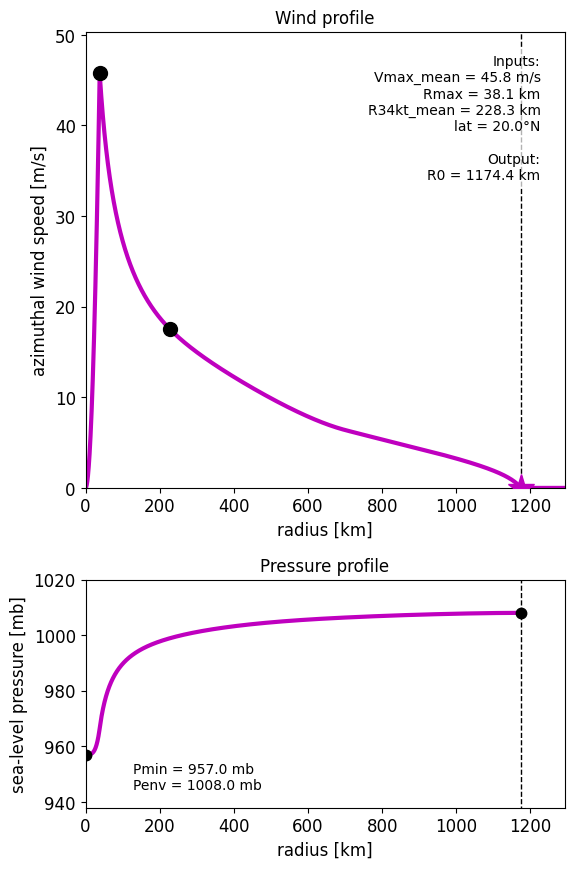

(<Figure size 590.551x885.827 with 2 Axes>,
 (<Axes: title={'center': 'Wind profile'}, xlabel='radius [km]', ylabel='azimuthal wind speed [m/s]'>,
  <Axes: title={'center': 'Pressure profile'}, xlabel='radius [km]', ylabel='sea-level pressure [mb]'>))

In [ ]:
################################################################
## Plot that data
from tcwindprofile.plot_windprofile import plot_wind_and_pressure

# unpack
rr_km   = tc_wind_and_pressure_profile['rr_km']
vv_ms   = tc_wind_and_pressure_profile['vv_ms']
pp_mb   = tc_wind_and_pressure_profile['pp_mb']
Vmaxmean_ms   = tc_wind_and_pressure_profile['Vmaxmean_ms']
Rmax_km   = tc_wind_and_pressure_profile['Rmax_km']
V34kt_ms   = tc_wind_and_pressure_profile['V34kt_ms']
R34ktmean_km   = tc_wind_and_pressure_profile['R34ktmean_km']
R0_km   = tc_wind_and_pressure_profile['R0_km']
lat   = tc_wind_and_pressure_profile['lat']
Penv_mb   = tc_wind_and_pressure_profile['Penv_mb']
Pmin_mb   = tc_wind_and_pressure_profile['Pmin_mb']


# then:
Renv_km = R0_km
plot_wind_and_pressure(
    rr_km, vv_ms,
    Rmax_km, Vmaxmean_ms,
    R34ktmean_km, V34kt_ms,
    R0_km, lat,
    rr_km, pp_mb,
    Renv_km, Penv_mb, Pmin_mb,
    save_path='tc_wind_pressure_profiles'
)
################################################################

# TEST INDIVIDUAL COMPONENTS (if desired)

In [ ]:
############################################################
## TEST INDIVIDUAL COMPONENTS: in case you want just one #####
############################################################
############################################################

print("\nTESTING INDIVIDUAL PARTS NEXT: in case you want just one\n")


TESTING INDIVIDUAL PARTS NEXT: in case you want just one



In [ ]:
############################################################
############################################################
############################################################
# Unit conversions to MKS
ms_per_kt = 0.5144444   # 1 kt = 0.514444 m/s
km_nautmi = 1.852
VmaxNHC_ms = VmaxNHC_kt * ms_per_kt
Vtrans_ms = Vtrans_kt * ms_per_kt
R34ktNHCquadmax_m_temp = km_nautmi * R34ktNHCquadmax_nautmi * 1000 #[m]

# Additional conversions
fac_R34ktNHCquadmax2mean = 0.85  #Eq 1 of CKK25 -- simple estimate of mean R34kt radius from NHC R34kt (which is maximum radius of 34kt); factor originally from DeMaria et al. (2009)
R34ktmean_km = R34ktNHCquadmax_m_temp * fac_R34ktNHCquadmax2mean / 1000 #[km]

Vmaxmean_ms = VmaxNHC_ms - 0.55 * Vtrans_ms
###############################################################

In [ ]:
###############################################################
# Estimate Rmax from Vmax, R34kt, and latitude
### Source: Chavas D.R. and J. A.. Knaff (2022). A simple model for predicting the tropical cyclone radius of maximum wind from outer size. Wea. For., 37(5), pp.563-579
### https://doi.org/10.1175/WAF-D-21-0103.1

from tcwindprofile.tc_rmax_estimatefromR34kt import predict_Rmax_from_R34kt

Rmax_estimate_km = predict_Rmax_from_R34kt(
        VmaxNHC_ms=VmaxNHC_ms,
        R34ktmean_km=R34ktmean_km,
        lat=lat
    )
print(f"Estimated Rmax = {Rmax_estimate_km:.1f} km")
# print(f"Estimated Rmax = {Rmax_estimate_nautmi:.1f} naut mi")
###############################################################

Returning estimated radius of maximum wind [km]
Estimated Rmax = 38.1 km


In [ ]:
###############################################################
# Retrieve estimated outer radius R0 ONLY
# (If you dont need the entire wind profile)

from tcwindprofile.tc_outer_radius_estimate import estimate_outer_radius

V34kt_ms = 34 * ms_per_kt           # [m/s]; outermost radius to calculate profile
R34ktmean_m = R34ktmean_km * 1000
omeg = 7.292e-5  # Earth's rotation rate
fcor = 2 * omeg * math.sin(math.radians(abs(lat)))  # [s^-1]
R0 = estimate_outer_radius(R34ktmean_m=R34ktmean_m, V34kt_ms=V34kt_ms, fcor=fcor)
print(f"Estimated R0 = {R0/1000:.1f} km")

Estimated R0 = 1174.4 km


In [ ]:
###############################################################
# Create wind profile
## Create a fast and robust radial profile of the tropical cyclone rotating wind from inputs Vmax, R34kt, Rmax, and latitude.
#### This code uses a modified‐Rankine vortex between Rmax and R34kt and the E04 model beyond R34kt (and a quadratic profile inside the eye). It is very similar to the full physics-based wind profile model of Chavas et al. (2015) ([code here](http://doi.org/10.4231/CZ4P-D448)), but is simpler and much faster.
#### It is designed to guarantee that the profile fits both Rmax and R34kt and will be very close to the true outer radius (R0) as estimated by the full E04 outer solution. Hence, it is very firmly grounded in the known physics of the tropical cyclone wind field while also matching the input data. It is also guaranteed to be very well‐behaved for basically any input parameter combination.
#### Model basis:
#### Modified Rankine profile between Rmax and R34kt was shown to compare very well against high-quality subset of Atlantic Best Track database -- see Fig 8 of [Klotzbach et al. (2022, JGR-A)](https://doi.org/10.1029/2022JD037030)
#### Physics-based non-convecting wind field profile beyond R34kt was shown to compare very well against entire QuikSCAT database -- see Fig 6 of [Chavas et al. (2015, JAS)](https://doi.org/10.1175/JAS-D-15-0014.1)
#### Quadratic in the eye (U-shape is common)

from tcwindprofile import generate_wind_profile

Rmax_km = Rmax_estimate_km
# Rmax_km = 38.1
rr_km, vv_ms, R0_estimate_km = generate_wind_profile(
    Vmaxmean_ms=Vmaxmean_ms,
    Rmax_km=Rmax_km,
    R34ktmean_km=R34ktmean_km,
    lat=lat,
    plot=False
)
print(f"Estimated R0 = {R0_estimate_km:.1f} km")
# No plot
# rr_km, vv_ms, R0_km = generate_wind_profile(Vmaxmean_ms, Rmax_km, R34ktmean_km, lat)
# print(f"Estimated R0 = {R0_estimate_km:.1f} km")

Returning radius vector [km], wind speed vector [m/s], estimated outer radius [km]
Estimated R0 = 1174.4 km


In [ ]:
###############################################################
# Estimate Pmin from Vmax, R34kt, latitude, translation speed, Penv
### Source: Chavas D.R., Knaff J.A. and P. Klotzbach  (2025). A Simple Model for Predicting Tropical Cyclone Minimum Central Pressure from Intensity and Size. Wea. For., 40(2), pp.333-346
### https://doi.org/10.1175/WAF-D-24-0031.1

from tcwindprofile.tc_pmin_estimatefromR34kt import predict_Pmin_from_R34kt

Pmin_estimate_mb, dP_estimate_mb = predict_Pmin_from_R34kt(
        VmaxNHC_ms=VmaxNHC_ms,
        R34ktmean_km=R34ktmean_km,
        lat=lat,
        Vtrans_ms=Vtrans_ms,
        Penv_mb=Penv_mb
    )
print(f"Estimated Pmin = {Pmin_estimate_mb:.1f} mb")
print(f"Estimated dP = {dP_estimate_mb:.1f} mb")
###############################################################

Returning minimum central sea-level pressure [mb]
Estimated Pmin = 957.0 mb
Estimated dP = -51.0 mb


In [ ]:
###########################
# Calculate pressure profile from wind field and matches Pmin
from tcwindprofile.pressure_profile import pressure_profile_calcfromwindprofile                        # [deg]

pp_mb = pressure_profile_calcfromwindprofile(
    rr_km=rr_km,
    vv_ms=vv_ms,
    Renv_km=R0_estimate_km,
    Penv_mb=Penv_mb,
    Pmin_mb=Pmin_estimate_mb,
    lat=lat,
    plot=False)

Returning sea-level pressure vector [mb] along input radius vector [km]
